# load iridium data and process

In [1]:
import os
from glob import glob

import pandas as pd
import xarray as xr

# cognac data and tools
import cognac.insitu as iu

---
## load and select data

In [2]:
# data directory and filename

#campaign = 'microco_leg2'
#campaign = 'lopstech19_leg1'
#campaign = 'cognac20'
campaign = 'sumos21'

cp = iu.campaign(campaign)

#data_dir = cp.path+'iridium/'
#imeis={unit: cp[unit]['iridium'] for unit in ['source', 'enregistreur']}
#imeis={unit: cp[unit]['iridium'] for unit in ['source', 'enregistreur']}

cp

cognac.insitu.events.campaign(sumos21 2021/02/22 to 2021/03/03)

## utils

In [3]:
def get_inputs(cp, unit):
    """ Point to correct Iridium files
    """

    if not 'instruments' in cp[unit] or 'iridium' not in cp[unit]['instruments']:
        return None, None

    imei = cp[unit]['instruments']['iridium']
    
    if cp.name=='cognac20':
        # cognac20
        dummy_path = 'home1/triagoz/intranet/htdocs/LOPStrack/DATA/'
        imei_file = cp.path+'iridium/'+dummy_path+'{}/synthese_{}.txt'.format(imei, imei)
        reader=0

    elif cp.name=='sumos21':
        # sumos
        if isinstance(cp[unit]['path'], list):
            imei_file = [p+'iridium/Balise_Iridium_{}.txt'.format(imei) for p in cp[unit]['path']]
        else:
            imei_file = cp[unit]['path']+'iridium/Balise_Iridium_{}.txt'.format(imei)
        reader=1
        
    return imei_file, reader

In [6]:
def load_iridium(unit, imei_file, reader):
    
    if imei_file is None or reader is None:
        return
    
    if not 'instruments' in unit or 'iridium' not in unit['instruments']:
        return

    gps = load_iridium_core(imei_file, reader)
    
    if gps:
        # trim and divide to keep deployments time
        gps = {d.label: gps.clean(d, inplace=False) for d in unit}
    
    return gps
    
def load_iridium_core(imei_file, reader):
    
    if isinstance(imei_file, list):
        gps = [load_iridium_core(f, reader) for f in imei_file]
        gps = [g for g in gps if g is not None]
        if len(gps)==1:
            return gps[0]
        else:
            return sum(gps)
    
    if not os.path.isfile(imei_file):
        print('No file found: '+imei_file)
        return
    
    if reader==0:
        # from LOPS track
        df = pd.read_csv(imei_file,
                        sep='\t+',
                        parse_dates=[0],
                        infer_datetime_format=True,
                        index_col=False,
                        names=['time', 'lat', 'lon', 'latlon0'],
                         )
    elif reader==1:
        # SUMOS Iridium file
        # it is simpler to rename columns afterwards in this case
        df = pd.read_csv(imei_file,
                        sep='\s+',
                        #parse_dates=[0,1],
                        #infer_datetime_format=True,
                        #dayfirst=True,
                        index_col=False,
                         header=None,
                         )
        df['time'] = pd.to_datetime(df[0] + ' ' + df[1], dayfirst=True)
        df = df[['time',2,3]].rename(columns={2: 'lat', 3: 'lon'})
        
    df = df.set_index('time').sort_index()
    
    # transform into a gps instance
    gps = iu.gps.gps(lon=df.lon, lat=df.lat, time=df.index)

    return gps

In [7]:
unit = 'emetteur'
unit = 'recepteur0'
imei = cp[unit]['instruments']['iridium']
print(unit, imei)

imei_file, reader = get_inputs(cp, unit)

gps = load_iridium(cp[unit], imei_file, reader)
gps

recepteur0 300434064252900


{'d1_synchro_start': cognac.insitu.gps.gps(gps - 0 points),
 'd1': cognac.insitu.gps.gps(gps - 80 points),
 'd1_synchro_end': cognac.insitu.gps.gps(gps - 0 points)}

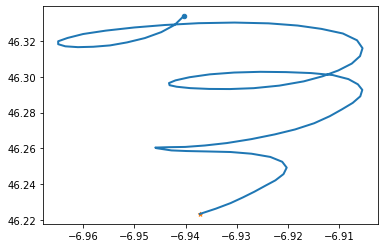

In [8]:
gps['d1'].plot()

---
## process all units

In [9]:
# load and store data for all units
for unit in cp:
    
    imei_file, reader = get_inputs(cp, unit)
    
    gps = load_iridium(cp[unit], imei_file, reader)
    
    #if os.path.isfile(imei_file):    
    #    gps = load_iridium(cp[unit], imei_file, reader)
    #else:
    #    gps = None
    
    # store
    if gps:
        for label, lgps in gps.items():
            if lgps:
                lgps.to_nc(cp.pathp+unit+'_iridium_'+label+'.nc')

Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/emetteur_iridium_d1.nc
Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/recepteur0_iridium_d1.nc
Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/recepteur1_iridium_d1.nc
No file found: /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/deploiement0/recepteur2/iridium/Balise_Iridium_300434064301970.txt
Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/recepteur2_iridium_d1.nc


---
## reload units and plot trajectories

In [10]:
iridium = cp.load('iridium')

In [11]:
cp

iridium_files = glob(cp.pathp+'*_iridium_*.nc')
units = set(f.split('/')[-1].split('_')[0] for f in iridium_files)

iridium = {}
for u in units:
    deployments = [f.split('/')[-1].split('_')[2].split('.')[0] for f in glob(cp.pathp+u+'_iridium_*.nc')]
    iridium[u] = {d: iu.gps.gps(file=cp.pathp+u+'_iridium_'+d+'.nc') for d in deployments}

iridium

{'recepteur0': {'d1': cognac.insitu.gps.gps(gps - 80 points)},
 'emetteur': {'d1': cognac.insitu.gps.gps(gps - 85 points)},
 'recepteur1': {'d1': cognac.insitu.gps.gps(gps - 91 points)},
 'recepteur2': {'d1': cognac.insitu.gps.gps(gps - 97 points)}}